This notebook is part of the $\omega radlib$ documentation: https://docs.wradlib.org.

Copyright (c) $\omega radlib$ developers.
Distributed under the MIT License. See LICENSE.txt for more info.

# Quick-view a sweep in polar or cartesian reference systems

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import wradlib as wrl
import wradlib_data
import warnings
import cmweather

warnings.filterwarnings("ignore")
try:
    get_ipython().run_line_magic("matplotlib inline")
except:
    plt.ion()

## Read a polar data set from the German Weather Service

In [2]:
filename = wradlib_data.DATASETS.fetch("dx/raa00-dx_10908-0806021735-fbg---bin.gz")
print(filename)

/home/runner/work/wradlib/wradlib/wradlib-data/dx/raa00-dx_10908-0806021735-fbg---bin.gz


In [3]:
img, meta = wrl.io.read_dx(filename)

Inspect the data set a little

In [4]:
print("Shape of polar array: %r\n" % (img.shape,))
print("Some meta data of the DX file:")
print("\tdatetime: %r" % (meta["datetime"],))
print("\tRadar ID: %s" % (meta["radarid"],))

Shape of polar array: (360, 128)

Some meta data of the DX file:
	datetime: datetime.datetime(2008, 6, 2, 17, 35, tzinfo=<UTC>)
	Radar ID: 10908


## The simplest plot

In [5]:
r = np.arange(img.shape[1], dtype=float)
r += (r[1] - r[0]) / 2.0
r *= 1000
az = np.arange(img.shape[0], dtype=float)
az += (az[1] - az[0]) / 2.0
img = wrl.georef.create_xarray_dataarray(img, r=r, phi=az, site=(10, 45, 0))
img

<xarray.DataArray (azimuth: 360, range: 128)> Size: 369kB
array([[  0. , -24. , -21. , ...,  28.5,  29. ,  35. ],
       [-13.5, -22. , -17. , ...,  15. ,   7. ,   3.5],
       [-32.5, -32.5, -32.5, ...,   6. ,   8.5,   9.5],
       ...,
       [  0.5, -17.5, -23. , ...,  33. ,  32.5,  29. ],
       [-11. , -21. , -20. , ...,  36. ,  34.5,  32.5],
       [-15. , -24. , -20.5, ...,  39. ,  37. ,  38. ]], shape=(360, 128))
Coordinates:
  * range       (range) float64 1kB 500.0 1.5e+03 ... 1.265e+05 1.275e+05
  * azimuth     (azimuth) float64 3kB 0.5 1.5 2.5 3.5 ... 357.5 358.5 359.5
    elevation   (azimuth) float64 3kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    longitude   int64 8B 10
    latitude    int64 8B 45
    altitude    int64 8B 0
    sweep_mode  <U20 80B 'azimuth_surveillance'

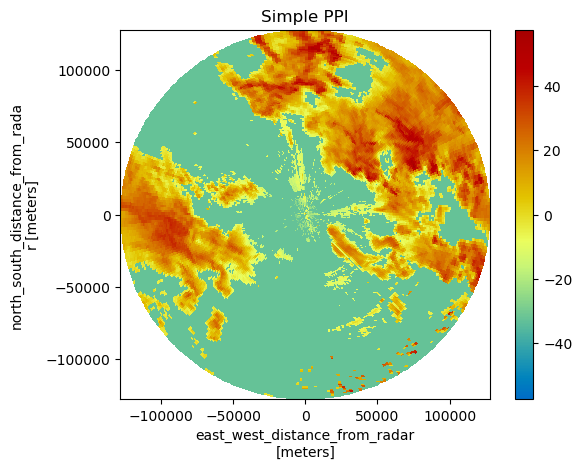

In [6]:
img = img.wrl.georef.georeference()
pm = img.wrl.vis.plot()
txt = plt.title("Simple PPI")

## Plot in curvelinear grid

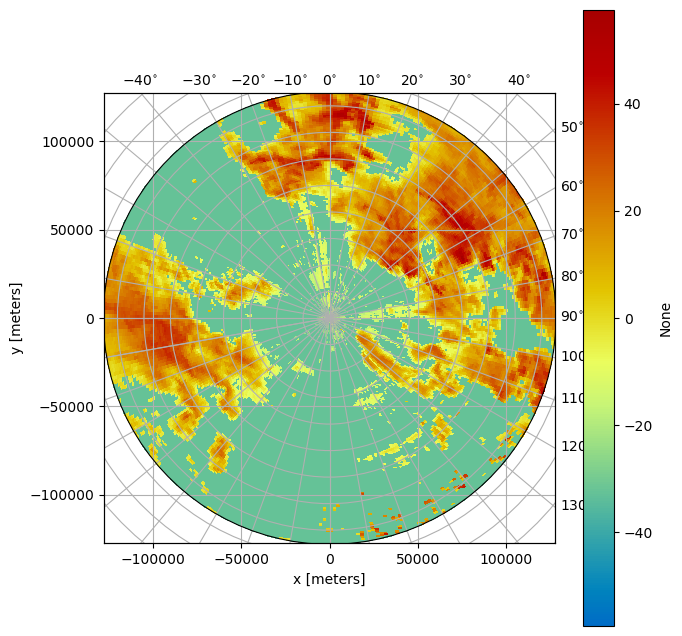

In [7]:
fig = plt.figure(figsize=(16, 8))
pm = img.wrl.vis.plot(crs="cg", ax=121, fig=fig)

## Plot in projected coordinate system

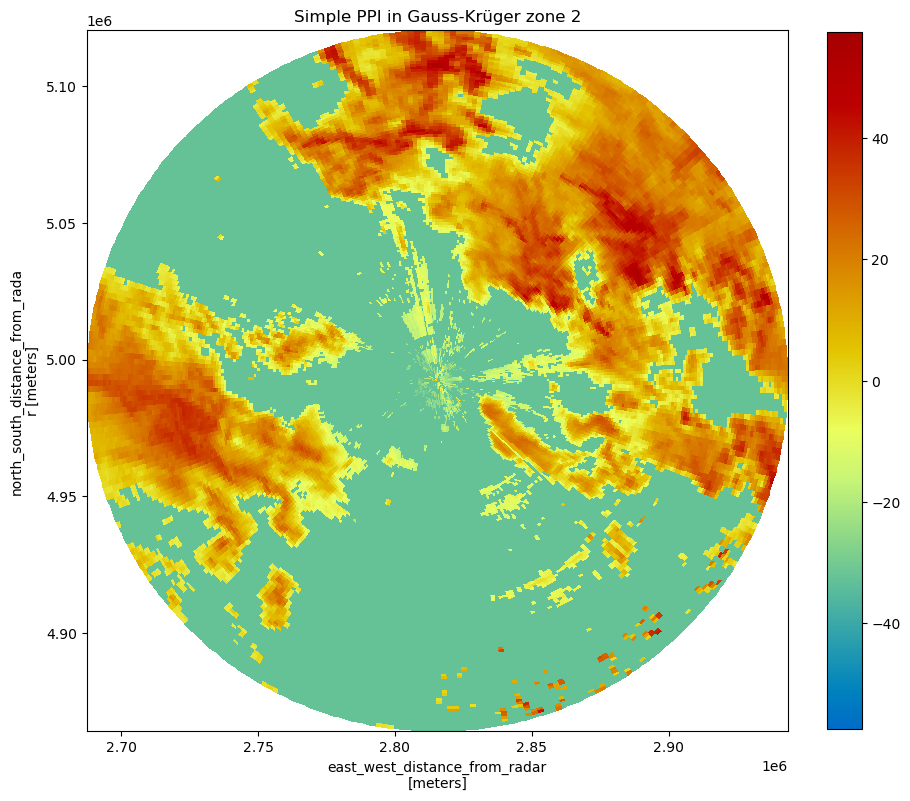

In [8]:
epsg = wrl.georef.epsg_to_osr(31466)
img = img.wrl.georef.georeference(crs=epsg)

fig = plt.figure(figsize=(10, 10))
pm = img.wrl.vis.plot(ax=111, fig=fig)
txt = plt.title("Simple PPI in Gauss-Krüger zone 2")

## Plot in WGS 84 coordinates

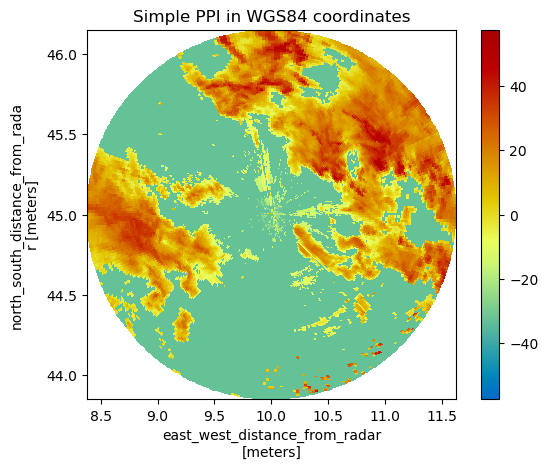

In [9]:
proj = wrl.georef.get_default_projection()
img = img.wrl.georef.georeference(crs=proj)

pm = img.wrl.vis.plot()
txt = plt.title("Simple PPI in WGS84 coordinates")

## Plotting just one sector

For this purpose, we need to give the ranges and azimuths explicitly...

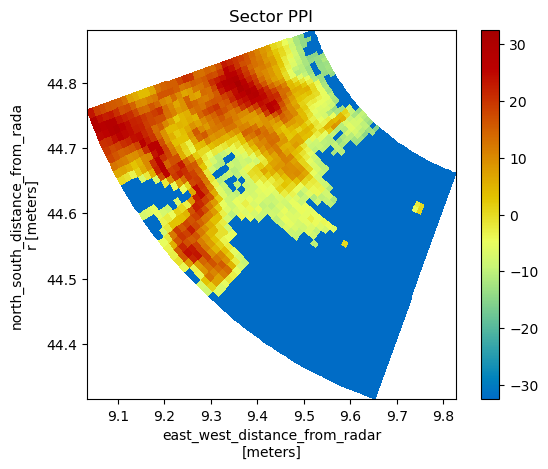

In [10]:
pm = img[200:251, 40:81].wrl.vis.plot()
txt = plt.title("Sector PPI")

## Adding a crosshair to the PPI 

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


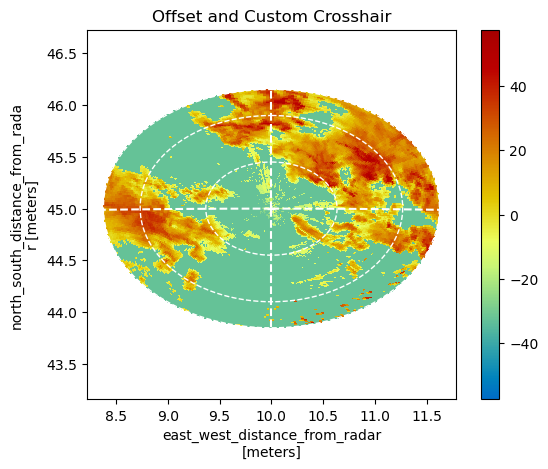

In [11]:
# plot the PPI
pm = img.wrl.vis.plot()
# ... plot a crosshair over our data...
ax = plt.gca()
# ... plot a crosshair over our data...
wrl.vis.plot_ppi_crosshair(
    site=(img.longitude.values, img.latitude.values, img.altitude.values),
    ranges=[50e3, 100e3, 128e3],
    angles=[0, 90, 180, 270],
    line=dict(color="white"),
    circle={"edgecolor": "white"},
    ax=ax,
    crs=proj,
)
plt.title("Offset and Custom Crosshair")
plt.axis("tight")
plt.gca().set_aspect("equal")

## Placing the polar data in a projected Cartesian reference system

Using the `proj` keyword we tell the function to:
- interpret the site coordinates as longitude/latitude
- reproject the coordinates to the given projection (here: dwd-radolan composite coordinate system)

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


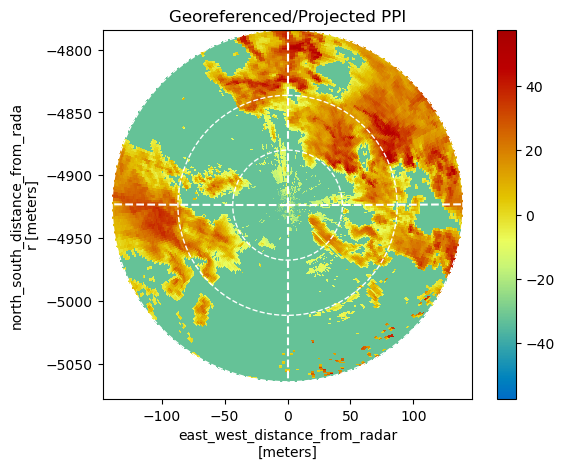

In [12]:
proj_rad = wrl.georef.create_osr("dwd-radolan")
img = img.wrl.georef.georeference(crs=proj_rad)
img.wrl.vis.plot()
ax = plt.gca()
# Now the crosshair ranges must be given in meters
wrl.vis.plot_ppi_crosshair(
    site=(img.longitude.values, img.latitude.values, img.altitude.values),
    ranges=[40000, 80000, 128000],
    line=dict(color="white"),
    circle={"edgecolor": "white"},
    ax=ax,
    crs=proj_rad,
)
plt.title("Georeferenced/Projected PPI")
plt.axis("tight")
plt.gca().set_aspect("equal")

## Some side effects of georeferencing

Transplanting the radar virtually moves it away from the central meridian of the projection (which is 10 degrees east). Due north now does not point straight upwards on the map.

The crosshair shows this: for the case that the lines should actually become curved, they are implemented as a piecewise linear curve with 10 vertices. The same is true for the range circles, but with more vertices, of course.

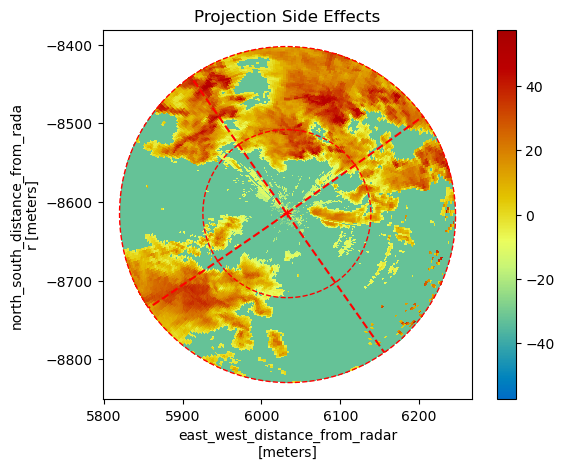

In [13]:
site = (45.0, 7.0, 0.0)
img["longitude"].values, img["latitude"].values = (45.0, 7.0)
img = img.wrl.georef.georeference(crs=proj_rad)
img.wrl.vis.plot()
ax = plt.gca()
ax = wrl.vis.plot_ppi_crosshair(
    site=(img.longitude.values, img.latitude.values, img.altitude.values),
    ranges=[64000, 128000],
    line=dict(color="red"),
    circle={"edgecolor": "red"},
    crs=proj_rad,
    ax=ax,
)
txt = plt.title("Projection Side Effects")

## Plot on Mercator-Map using cartopy 

In [14]:
import cartopy.crs as ccrs

map_proj = ccrs.Mercator(central_longitude=site[1])

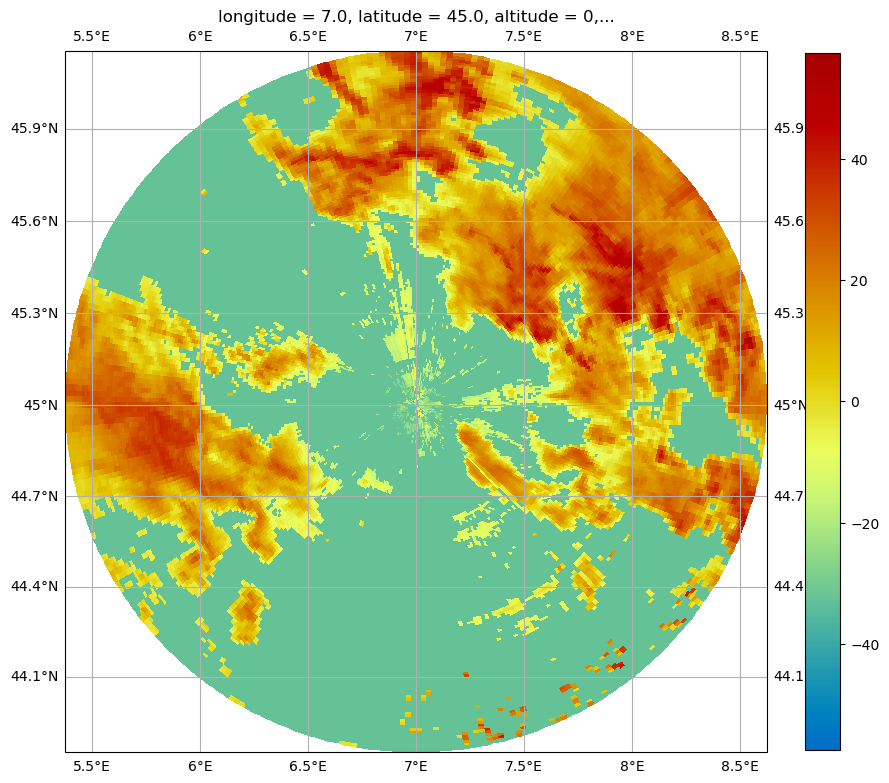

In [15]:
img["longitude"].values, img["latitude"].values = (7.0, 45.0)
img = img.wrl.georef.georeference()
fig = plt.figure(figsize=(10, 10))
img.wrl.vis.plot(crs=map_proj, fig=fig, ax=111)
ax = plt.gca()
ax.gridlines(draw_labels=True)

## More decorations and annotations

You can annotate these plots by using standard matplotlib methods.

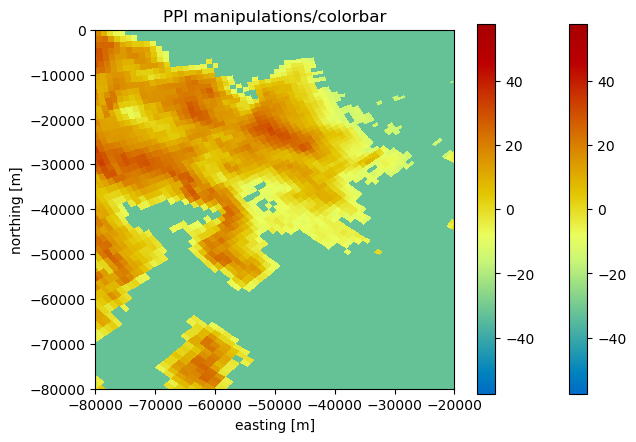

In [16]:
pm = img.wrl.vis.plot()
ax = plt.gca()
ylabel = ax.set_xlabel("easting [m]")
ylabel = ax.set_ylabel("northing [m]")
title = ax.set_title("PPI manipulations/colorbar")
# you can now also zoom - either programmatically or interactively
xlim = ax.set_xlim(-80000, -20000)
ylim = ax.set_ylim(-80000, 0)
# as the function returns the axes- and 'mappable'-objects colorbar needs, adding a colorbar is easy
cb = plt.colorbar(pm, ax=ax)